# TFT predictions

- Genero el dataset futuro con el pronóstico del tiempo, información de feriados y features de fecha
- Cargo el modelo entrenado
- Genero predicciones
- Grafico y veo interpretación del modelo

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from gdrive import drive_list_files, download_from_drive, check_existing_file
from argholidays import get_arg_holidays

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import joblib

from pytorch_forecasting import TimeSeriesDataSet, Baseline, TemporalFusionTransformer

from pytorch_forecasting.metrics import MAE, QuantileLoss

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger
import torch

import warnings
warnings.filterwarnings('ignore')

c:\Python\Python39\lib\site-packages\pytorch_forecasting\models\base_model.py:30: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


Dataset de ventas procesadas y mejoradas con features

In [2]:
folder_id = '1uepuL5iCVYies7GrC1YOW9Fws3NxA-Ex'
file_name = 'clean_sales.csv'
existing_files = drive_list_files(folder_id)
    
for file in existing_files:
    if file['title'] == file_name:
        file_id = file['id']
        break

if file_id:
    file_path = download_from_drive(file_id, file_name)

    sales_df = pd.read_csv(file_path)
    
sales_df.head()

,product,date,quantity,holiday,tempmax,tempmin,temp,precip,windspeed,cloudcover,weekday,month,year,weekend,lag_7,lag_365
0,Desayuno Campo,2022-01-01,0,1,30.1,12.7,24.0,0.0,40.7,54.9,5,1,2022,1,0.0,0.0
1,Desayuno Campo,2022-01-02,9,0,24.7,17.1,21.1,0.0,46.4,57.2,6,1,2022,1,11.0,0.0
2,Desayuno Campo,2022-01-03,6,0,32.2,11.2,22.1,0.0,50.0,71.9,0,1,2022,0,5.0,0.0
3,Desayuno Campo,2022-01-04,0,0,24.2,14.7,18.9,0.0,44.6,17.0,1,1,2022,0,0.0,0.0
4,Desayuno Campo,2022-01-05,4,0,28.7,11.9,20.6,0.0,33.5,25.9,2,1,2022,0,11.0,0.0


In [3]:
sales_df['date'] = pd.to_datetime(sales_df['date'])

date_range = pd.date_range(sales_df['date'].max() + pd.Timedelta(days=1), periods=7, freq='D')

date_range

DatetimeIndex(['2024-07-01', '2024-07-02', '2024-07-03', '2024-07-04',
               '2024-07-05', '2024-07-06', '2024-07-07'],
              dtype='datetime64[ns]', freq='D')

## Dataset futuro

In [4]:
# Creo un dataframe con todas las combinaciones de productos y fechas
all_products = sales_df['product'].unique()

full_grid = pd.MultiIndex.from_product([all_products, date_range], names=['product', 'date']).to_frame(index=False)

# Relleno los valores faltantes de quantity con 0
full_grid['quantity'] = 0

full_grid

,product,date,quantity
0,Desayuno Campo,2024-07-01,0
1,Desayuno Campo,2024-07-02,0
2,Desayuno Campo,2024-07-03,0
3,Desayuno Campo,2024-07-04,0
4,Desayuno Campo,2024-07-05,0
5,Desayuno Campo,2024-07-06,0
6,Desayuno Campo,2024-07-07,0
7,Medialuna,2024-07-01,0
8,Medialuna,2024-07-02,0
9,Medialuna,2024-07-03,0


Feriados

In [5]:
start_year = full_grid['date'].min().year

end_year = (full_grid['date'].max() + pd.Timedelta(weeks=52)).year

df_holidays = get_arg_holidays(start_year=start_year, end_year=end_year)

df_holidays.head()

,date,holiday
0,2024-01-01,1
1,2024-02-12,1
2,2024-02-13,1
3,2024-03-24,1
4,2024-03-29,1


In [6]:
df = pd.merge(full_grid, df_holidays, on='date', how='left')

# Relleno los valores faltantes en 'holiday' con 0 y me aseguro que tenga formato int
df['holiday'].fillna(0, inplace=True)

df['holiday'] = df['holiday'].astype(int)

df.head()

,product,date,quantity,holiday
0,Desayuno Campo,2024-07-01,0,0
1,Desayuno Campo,2024-07-02,0,0
2,Desayuno Campo,2024-07-03,0,0
3,Desayuno Campo,2024-07-04,0,0
4,Desayuno Campo,2024-07-05,0,0


Clima

In [7]:
file_name = 'rawson 2024-07-01 to 2024-07-31.csv'
existing_files = drive_list_files(folder_id)
    
for file in existing_files:
    if file['title'] == file_name:
        file_id = file['id']
        break

if file_id:
    file_path = download_from_drive(file_id, file_name)

    df_clima = pd.read_csv(file_path)


selected_columns = ['datetime', 'tempmax', 'tempmin', 'temp', 'precip', 'windspeed', 'cloudcover']

df_clima = df_clima[selected_columns]

df_clima.head()

,datetime,tempmax,tempmin,temp,precip,windspeed,cloudcover
0,2024-07-01,10.8,-0.3,4.4,0,26.0,27.8
1,2024-07-02,6.1,-0.3,2.7,6,19.0,82.3
2,2024-07-03,10.8,-1.3,3.3,0,37.4,14.8
3,2024-07-04,7.9,2.2,4.6,0,40.7,12.7
4,2024-07-05,7.2,-0.4,3.7,0,42.1,52.5


In [8]:
df_clima['datetime'] = pd.to_datetime(df_clima['datetime'])

df = pd.merge(df, df_clima, left_on='date', right_on='datetime', how='left')

df = df.drop(columns=['datetime'])

df

,product,date,quantity,holiday,tempmax,tempmin,temp,precip,windspeed,cloudcover
0,Desayuno Campo,2024-07-01,0,0,10.8,-0.3,4.4,0,26.0,27.8
1,Desayuno Campo,2024-07-02,0,0,6.1,-0.3,2.7,6,19.0,82.3
2,Desayuno Campo,2024-07-03,0,0,10.8,-1.3,3.3,0,37.4,14.8
3,Desayuno Campo,2024-07-04,0,0,7.9,2.2,4.6,0,40.7,12.7
4,Desayuno Campo,2024-07-05,0,0,7.2,-0.4,3.7,0,42.1,52.5
5,Desayuno Campo,2024-07-06,0,0,6.7,-4.2,0.5,0,9.4,45.4
6,Desayuno Campo,2024-07-07,0,0,7.9,-5.0,0.6,0,22.3,45.6
7,Medialuna,2024-07-01,0,0,10.8,-0.3,4.4,0,26.0,27.8
8,Medialuna,2024-07-02,0,0,6.1,-0.3,2.7,6,19.0,82.3
9,Medialuna,2024-07-03,0,0,10.8,-1.3,3.3,0,37.4,14.8


Features de fecha

In [9]:
df['weekday'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['weekend'] = (df['date'].dt.weekday >= 5).astype(int)

df

,product,date,quantity,holiday,tempmax,tempmin,temp,precip,windspeed,cloudcover,weekday,month,year,weekend
0,Desayuno Campo,2024-07-01,0,0,10.8,-0.3,4.4,0,26.0,27.8,0,7,2024,0
1,Desayuno Campo,2024-07-02,0,0,6.1,-0.3,2.7,6,19.0,82.3,1,7,2024,0
2,Desayuno Campo,2024-07-03,0,0,10.8,-1.3,3.3,0,37.4,14.8,2,7,2024,0
3,Desayuno Campo,2024-07-04,0,0,7.9,2.2,4.6,0,40.7,12.7,3,7,2024,0
4,Desayuno Campo,2024-07-05,0,0,7.2,-0.4,3.7,0,42.1,52.5,4,7,2024,0
5,Desayuno Campo,2024-07-06,0,0,6.7,-4.2,0.5,0,9.4,45.4,5,7,2024,1
6,Desayuno Campo,2024-07-07,0,0,7.9,-5.0,0.6,0,22.3,45.6,6,7,2024,1
7,Medialuna,2024-07-01,0,0,10.8,-0.3,4.4,0,26.0,27.8,0,7,2024,0
8,Medialuna,2024-07-02,0,0,6.1,-0.3,2.7,6,19.0,82.3,1,7,2024,0
9,Medialuna,2024-07-03,0,0,10.8,-1.3,3.3,0,37.4,14.8,2,7,2024,0


Concateno con histórico y agrego variables de lag

In [10]:
combined_df = pd.concat([sales_df, df], ignore_index=True)

# Ordeno por fecha
combined_df = combined_df.sort_values(by='date')

combined_df.set_index('date', inplace=True)

# Calculo lag_7 y lag_365
combined_df['lag_7'] = combined_df.groupby('product')['quantity'].shift(7)
combined_df['lag_365'] = combined_df.groupby('product')['quantity'].shift(365)

combined_df.reset_index(inplace=True)

Me quedo sólo con los últimos 7 días

In [11]:
last_date = combined_df['date'].max()

df = combined_df[combined_df['date'] > (last_date - pd.Timedelta(days=7))]

df.reset_index(inplace=True)

df

,index,date,product,quantity,holiday,tempmax,tempmin,temp,precip,windspeed,cloudcover,weekday,month,year,weekend,lag_7,lag_365
0,4560,2024-07-01,Desayuno Campo,0,0,10.8,-0.3,4.4,0.0,26.0,27.8,0,7,2024,0,0.0,10.0
1,4561,2024-07-01,Para dos,0,0,10.8,-0.3,4.4,0.0,26.0,27.8,0,7,2024,0,1.0,12.0
2,4562,2024-07-01,Tostado JyQ,0,0,10.8,-0.3,4.4,0.0,26.0,27.8,0,7,2024,0,1.0,16.0
3,4563,2024-07-01,Medialuna con jamon y queso,0,0,10.8,-0.3,4.4,0.0,26.0,27.8,0,7,2024,0,2.0,9.0
4,4564,2024-07-01,Medialuna,0,0,10.8,-0.3,4.4,0.0,26.0,27.8,0,7,2024,0,4.0,11.0
5,4565,2024-07-02,Para dos,0,0,6.1,-0.3,2.7,6.0,19.0,82.3,1,7,2024,0,2.0,2.0
6,4566,2024-07-02,Medialuna con jamon y queso,0,0,6.1,-0.3,2.7,6.0,19.0,82.3,1,7,2024,0,1.0,3.0
7,4567,2024-07-02,Tostado JyQ,0,0,6.1,-0.3,2.7,6.0,19.0,82.3,1,7,2024,0,0.0,5.0
8,4568,2024-07-02,Medialuna,0,0,6.1,-0.3,2.7,6.0,19.0,82.3,1,7,2024,0,3.0,3.0
9,4569,2024-07-02,Desayuno Campo,0,0,6.1,-0.3,2.7,6.0,19.0,82.3,1,7,2024,0,1.0,1.0


Escalo las variables

In [12]:
# Inicio el escalador
scaler = MinMaxScaler()

# Escalo las features numéricas
features_to_scale = ['tempmax', 'tempmin', 'temp', 'precip', 'windspeed', 'cloudcover', 'quantity', 'lag_7', 'lag_365']
sales_df[features_to_scale] = scaler.fit_transform(sales_df[features_to_scale])

# Guardo el escalador para uso futuro
joblib.dump(scaler, 'scaler.pkl')

sales_df.head()

,product,date,quantity,holiday,tempmax,tempmin,temp,precip,windspeed,cloudcover,weekday,month,year,weekend,lag_7,lag_365
0,Desayuno Campo,2022-01-01,0.000000,1,0.692722,0.675758,0.826748,0.0,0.469937,0.549,5,1,2022,1,0.000000,0.0
1,Desayuno Campo,2022-01-02,0.230769,0,0.547170,0.809091,0.738602,0.0,0.560127,0.572,6,1,2022,1,0.282051,0.0
2,Desayuno Campo,2022-01-03,0.153846,0,0.749326,0.630303,0.768997,0.0,0.617089,0.719,0,1,2022,0,0.128205,0.0
3,Desayuno Campo,2022-01-04,0.000000,0,0.533693,0.736364,0.671733,0.0,0.531646,0.170,1,1,2022,0,0.000000,0.0
4,Desayuno Campo,2022-01-05,0.102564,0,0.654987,0.651515,0.723404,0.0,0.356013,0.259,2,1,2022,0,0.282051,0.0


In [13]:
# Escalo las variables numéricas del dataframe futuro de la misma manera
df[features_to_scale] = scaler.transform(df[features_to_scale])

df

,index,date,product,quantity,holiday,tempmax,tempmin,temp,precip,windspeed,cloudcover,weekday,month,year,weekend,lag_7,lag_365
0,4560,2024-07-01,Desayuno Campo,0.0,0,0.172507,0.281818,0.231003,0.00000,0.237342,0.278,0,7,2024,0,0.000000,0.256410
1,4561,2024-07-01,Para dos,0.0,0,0.172507,0.281818,0.231003,0.00000,0.237342,0.278,0,7,2024,0,0.025641,0.307692
2,4562,2024-07-01,Tostado JyQ,0.0,0,0.172507,0.281818,0.231003,0.00000,0.237342,0.278,0,7,2024,0,0.025641,0.410256
3,4563,2024-07-01,Medialuna con jamon y queso,0.0,0,0.172507,0.281818,0.231003,0.00000,0.237342,0.278,0,7,2024,0,0.051282,0.230769
4,4564,2024-07-01,Medialuna,0.0,0,0.172507,0.281818,0.231003,0.00000,0.237342,0.278,0,7,2024,0,0.102564,0.282051
5,4565,2024-07-02,Para dos,0.0,0,0.045822,0.281818,0.179331,0.02259,0.126582,0.823,1,7,2024,0,0.051282,0.051282
6,4566,2024-07-02,Medialuna con jamon y queso,0.0,0,0.045822,0.281818,0.179331,0.02259,0.126582,0.823,1,7,2024,0,0.025641,0.076923
7,4567,2024-07-02,Tostado JyQ,0.0,0,0.045822,0.281818,0.179331,0.02259,0.126582,0.823,1,7,2024,0,0.000000,0.128205
8,4568,2024-07-02,Medialuna,0.0,0,0.045822,0.281818,0.179331,0.02259,0.126582,0.823,1,7,2024,0,0.076923,0.076923
9,4569,2024-07-02,Desayuno Campo,0.0,0,0.045822,0.281818,0.179331,0.02259,0.126582,0.823,1,7,2024,0,0.025641,0.025641


Cargo el modelo TFT y genero predicciones

In [31]:
data = sales_df.copy()

# Creo una columna 'time index' basada en la posición de cada fecha
data['time_idx'] = data['date'].rank(method='dense').astype(int) - 1


max_encoder_length = 365
max_prediction_length = 7
training_cutoff = data['time_idx'].max() - max_prediction_length

# Preparo el dataset para la predicción
training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    group_ids=['product'],
    target='quantity',
    time_idx='time_idx',
    max_encoder_length=max_encoder_length,
    min_prediction_length=max_prediction_length,
    max_prediction_length=max_prediction_length,
    time_varying_known_reals=['holiday', 'tempmax', 'tempmin',
                              'temp', 'precip', 'windspeed', 'cloudcover',
                              'weekday', 'month', 'year', 'weekend'],
    time_varying_unknown_reals=['quantity']
)




# Cargo los pesos y los hiperparámetros del modelo guardado
checkpoint = torch.load(r"C:\\Users\\Usuario\\fudo-to-cloud\\tft.pth")

# Recreo el modelo utilizando los hiperparámetros guardados
loaded_model = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=checkpoint['model_hparams']['learning_rate'],
    hidden_size=checkpoint['model_hparams']['hidden_size'],
    attention_head_size=checkpoint['model_hparams']['attention_head_size'],
    dropout=checkpoint['model_hparams']['dropout'],
    hidden_continuous_size=checkpoint['model_hparams']['hidden_continuous_size'],
    output_size=checkpoint['model_hparams']['output_size'],
    loss=QuantileLoss(),
    log_interval=checkpoint['model_hparams']['log_interval'],
    reduce_on_plateau_patience=checkpoint['model_hparams']['reduce_on_plateau_patience']
)

# Cargo el state_dict
loaded_model.load_state_dict(checkpoint['model_state_dict'])


# Preparo el nuevo dataset para predicción
future_df = pd.concat([df, sales_df], ignore_index=True)

future_df['time_idx'] = future_df['date'].rank(method='dense').astype(int) - 1

future_dataset = TimeSeriesDataSet.from_dataset(training, future_df, predict=True, stop_randomization=True)
batch_size = 64
future_dataloader = future_dataset.to_dataloader(train=False, batch_size=batch_size, num_workers=3, persistent_workers=True)


# Realizo predicciones
raw_predictions = loaded_model.predict(future_dataloader, mode="raw", return_x=True)

raw_predictions

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Prediction(output=Output(prediction=tensor([[[-1.6026e-02, -6.3790e-04,  1.4577e-02,  4.1777e-02,  7.4783e-02,
           1.0840e-01,  1.6260e-01],
         [-2.2582e-02, -1.9104e-02, -1.4184e-02, -5.2269e-03,  2.7021e-03,
           1.1584e-02,  3.9136e-02],
         [-1.1673e-02, -1.3532e-04,  1.3928e-02,  3.7420e-02,  6.1567e-02,
           8.6152e-02,  1.3888e-01],
         [-9.6312e-03,  4.4567e-03,  1.7486e-02,  4.3323e-02,  7.2482e-02,
           9.7720e-02,  1.5941e-01],
         [-1.3222e-02,  3.8071e-03,  1.8282e-02,  4.5709e-02,  7.8553e-02,
           1.0605e-01,  1.7406e-01],
         [-1.4993e-04,  2.3092e-02,  4.4641e-02,  9.2279e-02,  1.3345e-01,
           1.7926e-01,  2.4990e-01],
         [ 7.4110e-03,  3.4655e-02,  6.5177e-02,  1.1629e-01,  1.6228e-01,
           2.1529e-01,  2.9056e-01]],

        [[-5.5777e-02, -3.2752e-02, -1.0034e-02,  3.0645e-02,  7.9999e-02,
           1.3024e-01,  2.1128e-01],
         [-6.5553e-02, -6.0339e-02, -5.3000e-02, -3.9565e-02, -2.7

Grafico

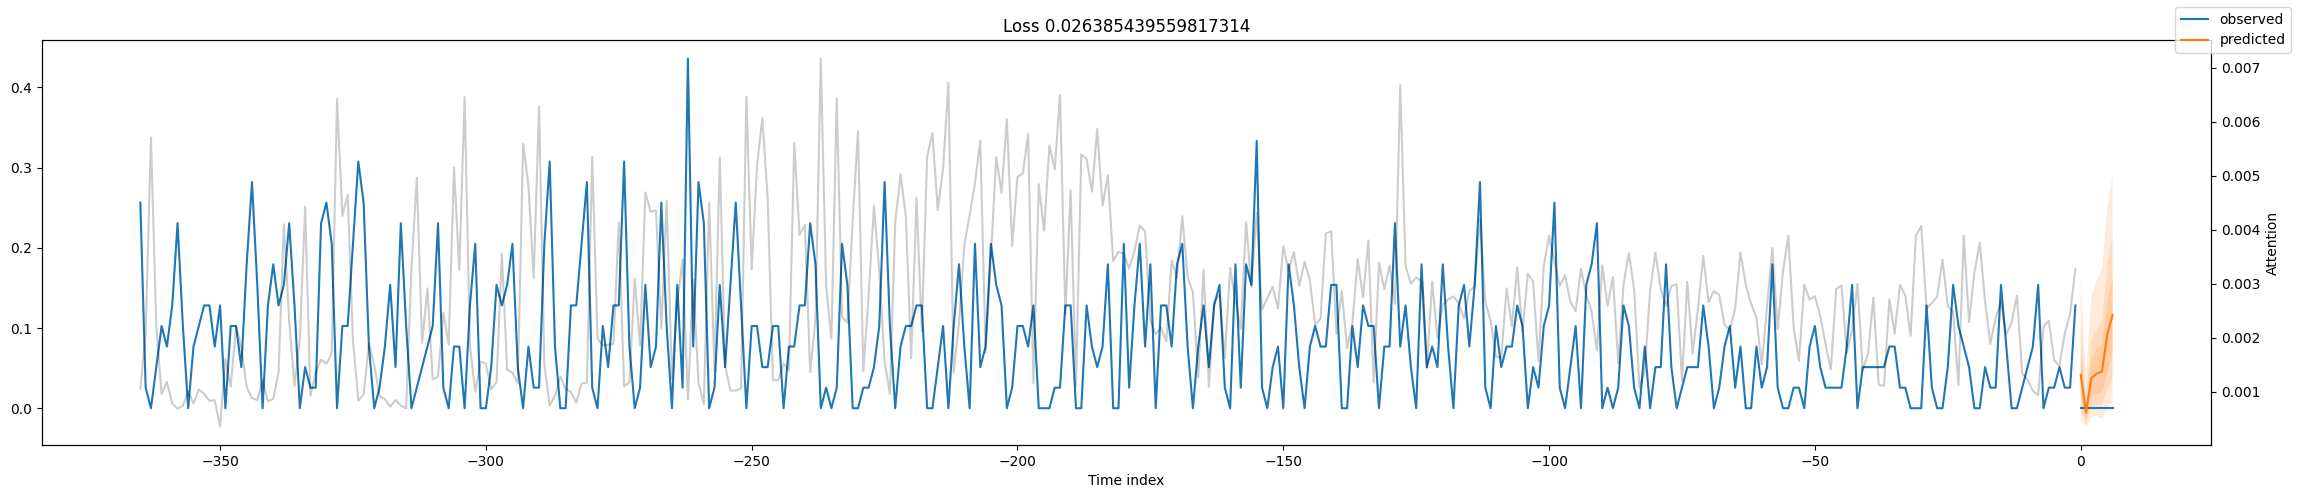

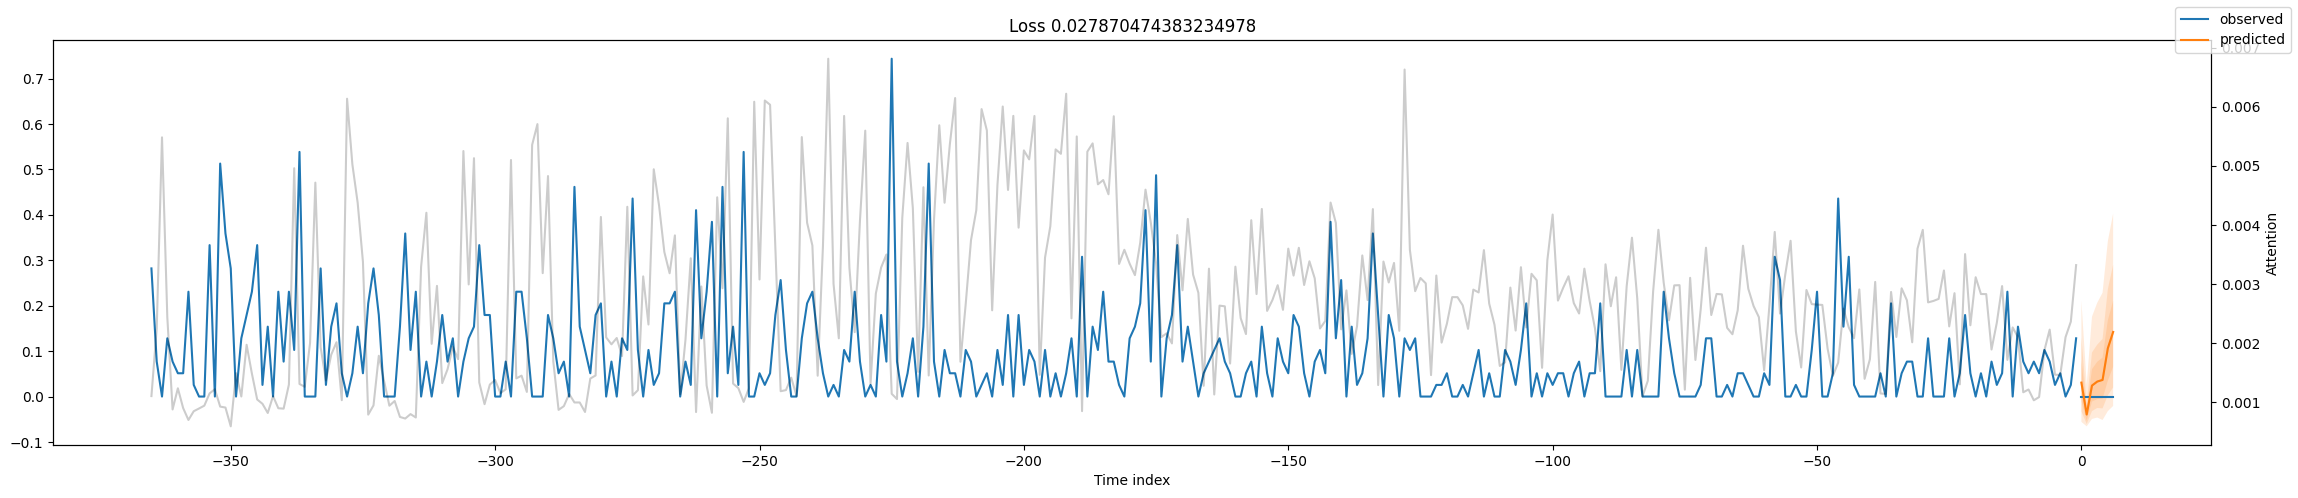

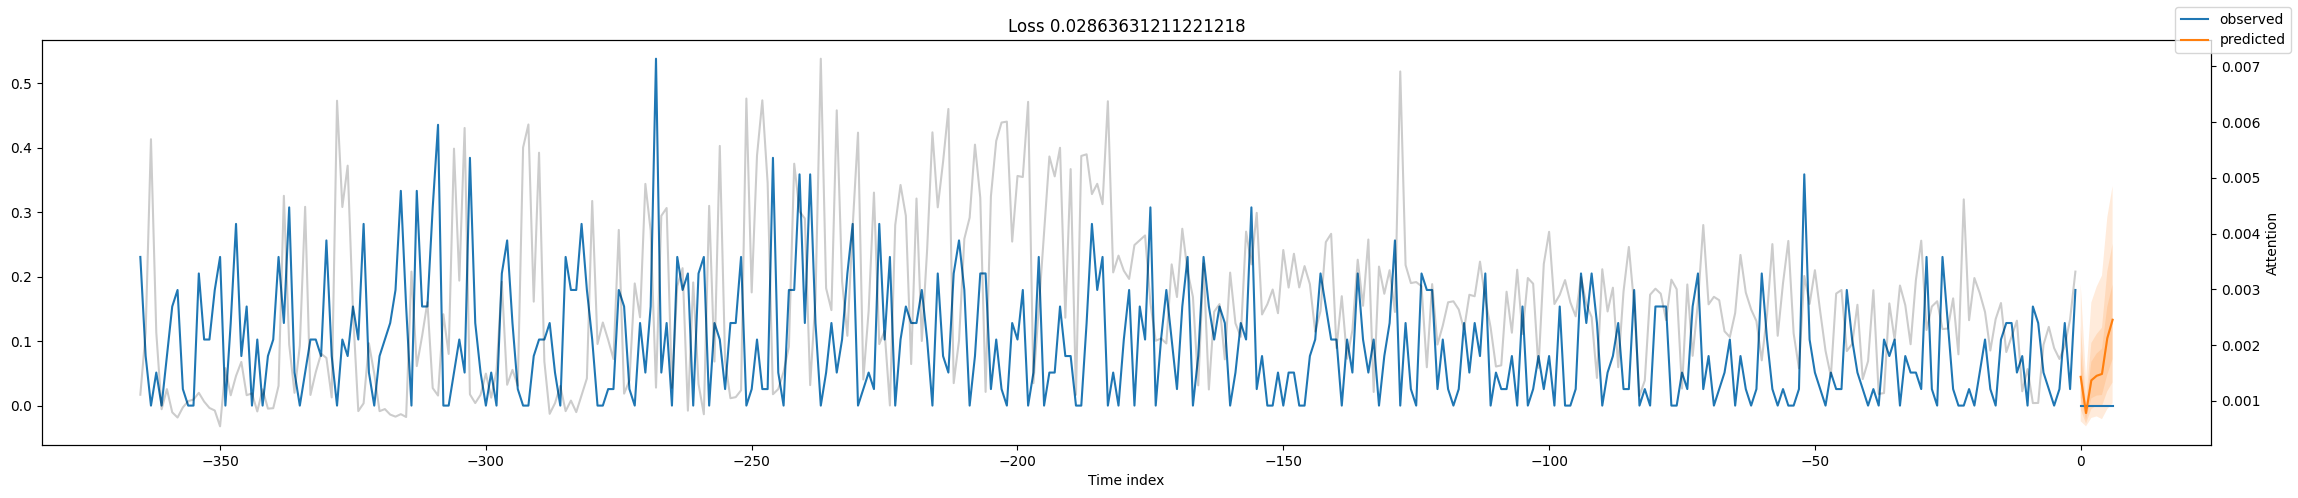

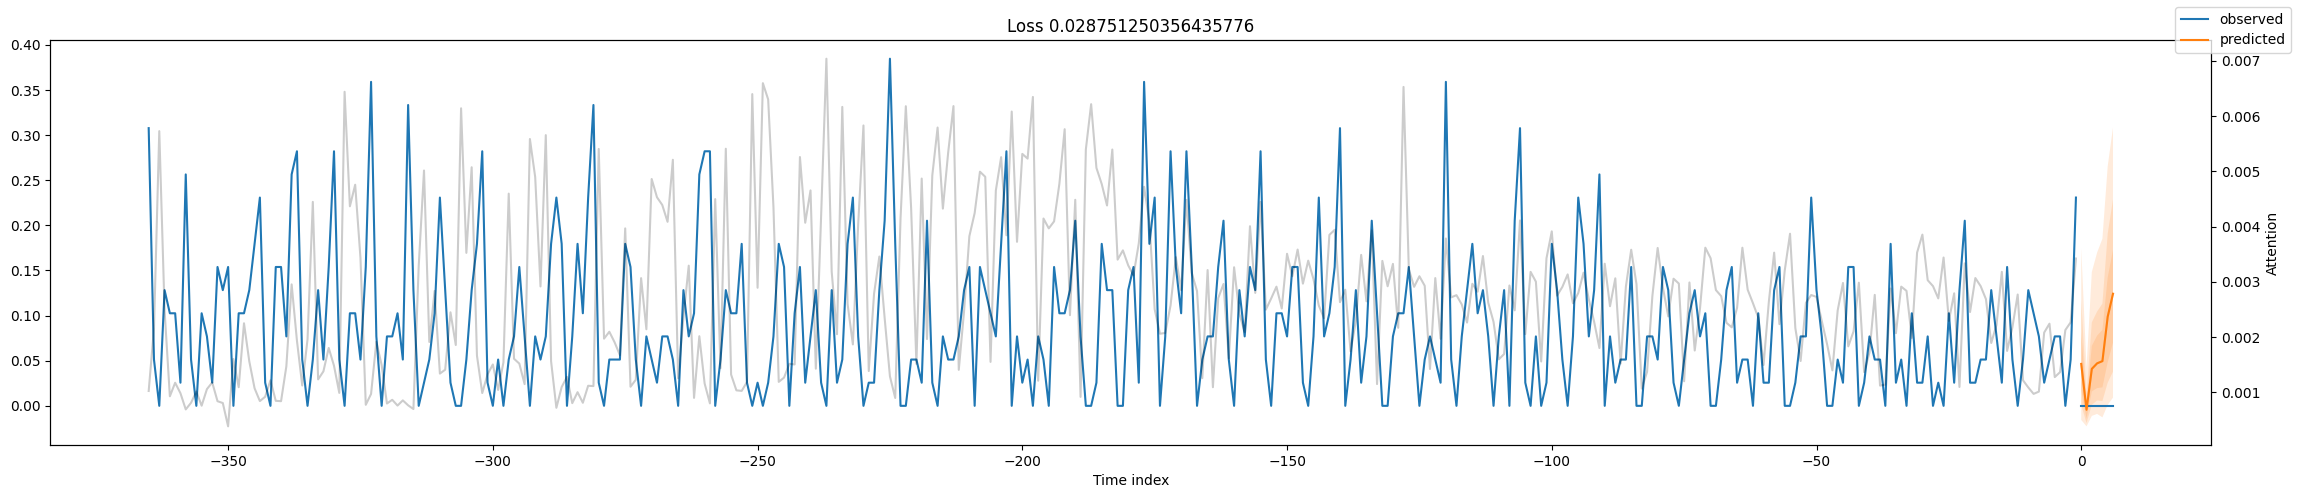

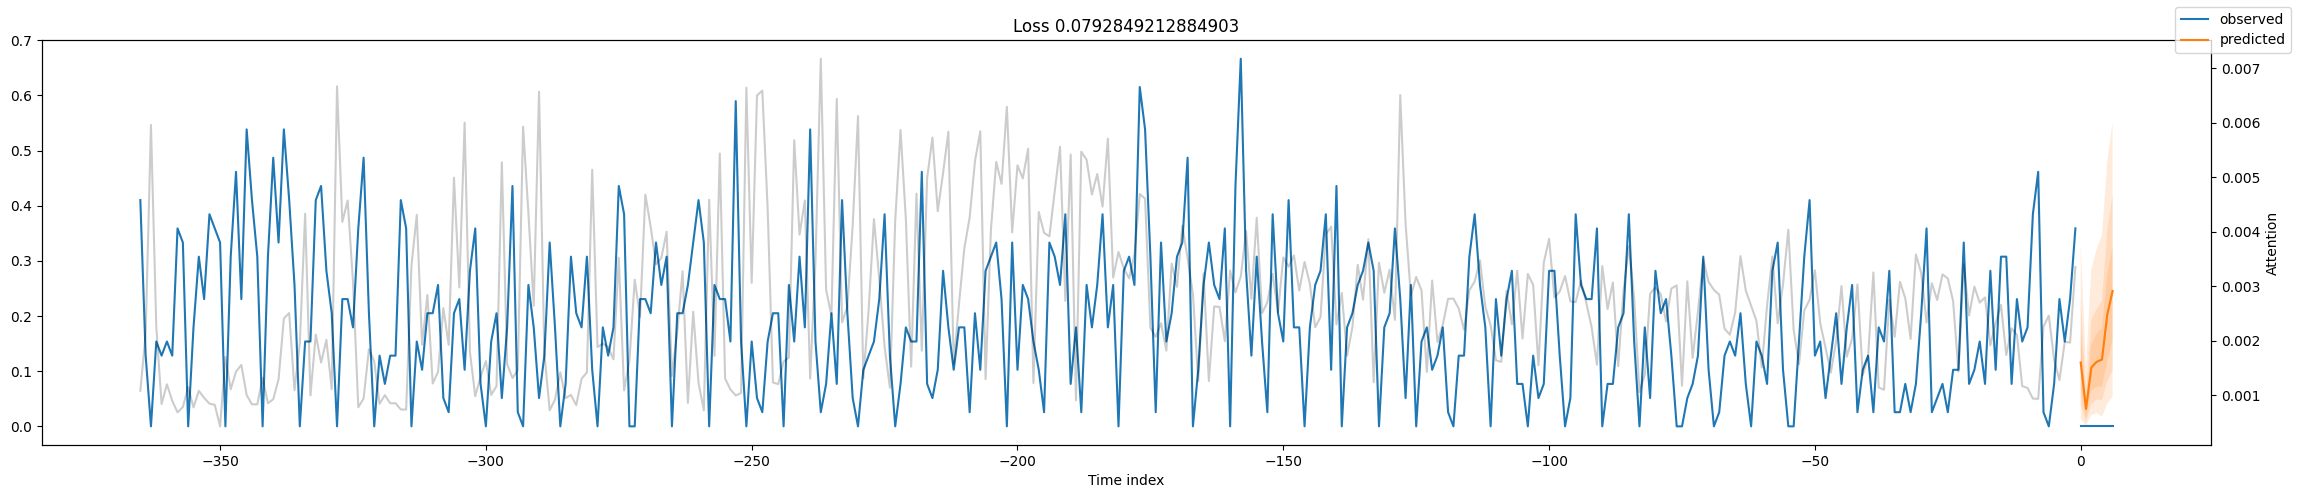

In [15]:
for idx in range(5):
    fig, ax = plt.subplots(figsize=(23,5))
    loaded_model.plot_prediction(raw_predictions.x,
                            raw_predictions.output,
                            idx=idx,
                            add_loss_to_title=True,
                            ax=ax);

Interpretación del modelo

{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x200 with 1 Axes>,
 'encoder_variables': <Figure size 700x500 with 1 Axes>,
 'decoder_variables': <Figure size 700x475 with 1 Axes>}

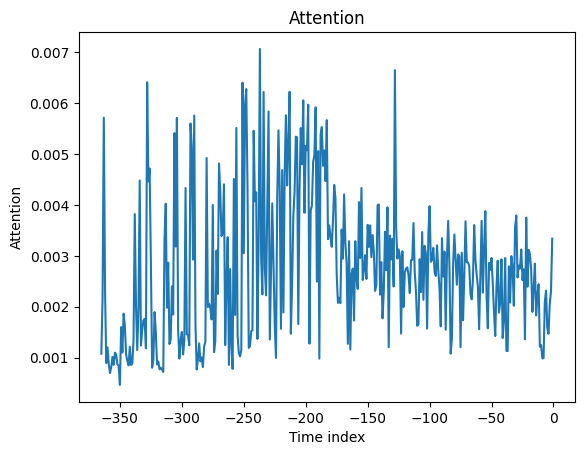

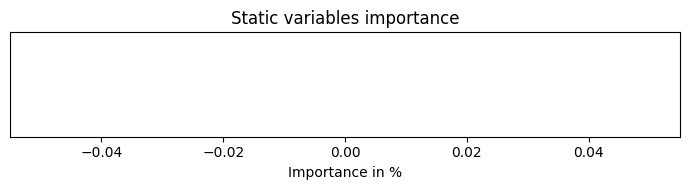

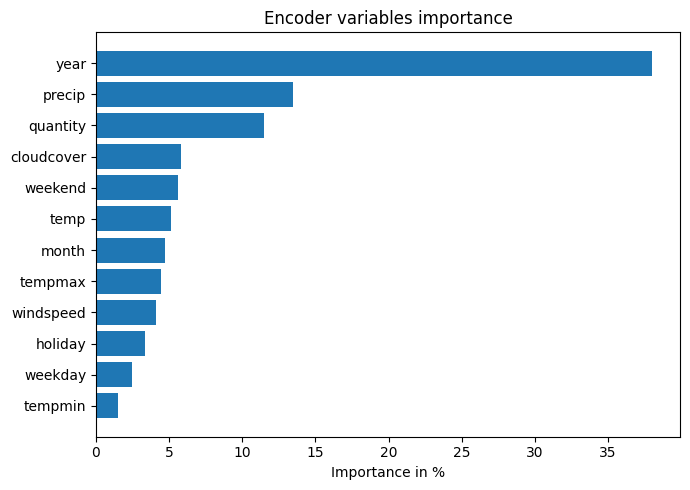

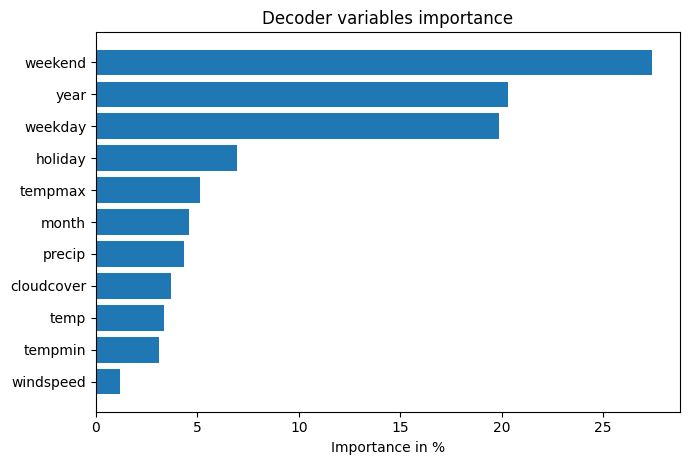

In [18]:
interpretation = loaded_model.interpret_output(raw_predictions.output, reduction="sum")
loaded_model.plot_interpretation(interpretation)